# Transcription Service Comparison Analysis

This notebook provides a comprehensive comparison of different transcription services:
- Amazon Transcribe
- Microsoft Word
- Otter.ai
- OpenAI Whisper API

All compared against a 100% accurate control transcript.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Loading and Preprocessing](#preprocessing)
3. [Text Cleaning and Normalization](#cleaning)
4. [Alignment and Segmentation](#alignment)
5. [Accuracy Metrics Calculation](#metrics)
6. [Advanced Error Analysis](#error-analysis)
7. [Visualization and Reporting](#visualization)
8. [Summary and Recommendations](#summary)


## 1. Setup and Imports {#setup}


In [1]:
# Core libraries
import pandas as pd
import numpy as np
import json
import re
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import difflib
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk

# Metrics
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
try:
    from Levenshtein import distance as levenshtein_distance
except ImportError:
    print("Warning: python-Levenshtein not installed. Installing fallback...")
    def levenshtein_distance(s1, s2):
        if len(s1) < len(s2):
            return levenshtein_distance(s2, s1)
        if len(s2) == 0:
            return len(s1)
        
        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        return previous_row[-1]

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from wordcloud import WordCloud
except ImportError:
    print("Warning: wordcloud not installed - word cloud features disabled")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('default')  # Using default instead of seaborn-v0_8 for compatibility
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


In [2]:
# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK data downloaded successfully!")
except:
    print("NLTK download failed - some features may not work")


NLTK data downloaded successfully!


## 2. Data Loading and Preprocessing {#preprocessing}


In [3]:
# Define file paths
base_path = Path('.')
control_path = base_path / 'Original MP3 and Control Transcript' / 'control.txt'
amazon_path = base_path / 'Other Transcripts' / 'amazon_transcribe.txt'
amazon_json_path = base_path / 'Other Transcripts' / 'asrOutput.json'
microsoft_path = base_path / 'Other Transcripts' / 'microsoft_word.txt'
otter_path = base_path / 'Other Transcripts' / 'otterai.txt'
whisper_path = base_path / 'Other Transcripts' / '2011_full.srt'

# Verify all files exist
files_to_check = {
    'Control': control_path,
    'Amazon': amazon_path,
    'Amazon JSON': amazon_json_path,
    'Microsoft': microsoft_path,
    'Otter.ai': otter_path,
    'Whisper SRT': whisper_path
}

for name, path in files_to_check.items():
    if path.exists():
        print(f"✓ {name}: {path}")
    else:
        print(f"✗ {name}: {path} - FILE NOT FOUND")


✓ Control: Original MP3 and Control Transcript/control.txt
✓ Amazon: Other Transcripts/amazon_transcribe.txt
✓ Amazon JSON: Other Transcripts/asrOutput.json
✓ Microsoft: Other Transcripts/microsoft_word.txt
✓ Otter.ai: Other Transcripts/otterai.txt
✓ Whisper SRT: Other Transcripts/2011_full.srt


In [4]:
def load_control_transcript(file_path):
    """Load and parse the control transcript with speaker labels."""
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    speakers = []
    segments = []
    current_speaker = None
    current_text = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        # Remove line numbers
        line = re.sub(r'^\s*\d+\|', '', line)
        
        # Check if this is a speaker name (short line, likely a name)
        if (len(line.split()) <= 3 and 
            line not in ['Commercial', 'and'] and
            not line.startswith('Welcome') and
            not line.startswith('Eagle Forum')):
            
            # Save previous segment if exists
            if current_speaker and current_text:
                speakers.append(current_speaker)
                segments.append(' '.join(current_text))
            
            # Start new segment
            current_speaker = line
            current_text = []
        else:
            # This is content
            if line:
                current_text.append(line)
    
    # Don't forget the last segment
    if current_speaker and current_text:
        speakers.append(current_speaker)
        segments.append(' '.join(current_text))
    
    # Create full text without speakers
    full_text = ' '.join(segments)
    
    return {
        'speakers': speakers,
        'segments': segments,
        'full_text': full_text,
        'speaker_segments': list(zip(speakers, segments))
    }

# Load control transcript
control_data = load_control_transcript(control_path)
print(f"Control transcript loaded:")
print(f"  - {len(control_data['segments'])} segments")
print(f"  - {len(set(control_data['speakers']))} unique speakers")
print(f"  - {len(control_data['full_text'].split())} total words")
print(f"\nSpeakers: {set(control_data['speakers'])}")


Control transcript loaded:
  - 120 segments
  - 3 unique speakers
  - 8088 total words

Speakers: {'Thomas Sowell', 'Phyllis Schlafly', 'Bill Hayes'}


In [5]:
def load_amazon_transcript(file_path):
    """Load Amazon Transcribe output."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Remove line numbers if present
    content = re.sub(r'^\s*\d+\|', '', content, flags=re.MULTILINE)
    
    # Clean up extra whitespace
    content = re.sub(r'\s+', ' ', content).strip()
    
    return {'full_text': content}

def load_amazon_json(file_path):
    """Load Amazon Transcribe JSON output and extract text."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extract transcript from JSON
    transcript = data['results']['transcripts'][0]['transcript']
    
    return {
        'full_text': transcript,
        'metadata': {
            'job_name': data.get('jobName', 'Unknown'),
            'status': data.get('status', 'Unknown')
        }
    }

def load_microsoft_transcript(file_path):
    """Load Microsoft Word transcript with speaker labels."""
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    speakers = []
    segments = []
    all_text = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Remove line numbers
        line = re.sub(r'^\s*\d+\|', '', line)
        
        # Check if this looks like a speaker label
        if (len(line.split()) <= 3 and 
            any(name in line for name in ['Phyllis', 'Thomas', 'Bill', 'Commercial']) and
            not line.startswith('Welcome')):
            speakers.append(line)
        else:
            if line:
                segments.append(line)
                all_text.append(line)
    
    full_text = ' '.join(all_text)
    
    return {
        'speakers': speakers,
        'segments': segments,
        'full_text': full_text
    }

def load_otter_transcript(file_path):
    """Load Otter.ai transcript (incomplete due to free version)."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Remove line numbers if present
    content = re.sub(r'^\s*\d+\|', '', content, flags=re.MULTILINE)
    
    # Clean up extra whitespace
    content = re.sub(r'\s+', ' ', content).strip()
    
    return {'full_text': content}

def load_whisper_srt(file_path):
    """Load OpenAI Whisper SRT file and extract text."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Remove line numbers
    content = re.sub(r'^\s*\d+\|', '', content, flags=re.MULTILINE)
    
    # Remove SRT timestamps (format: 00:00:00,000 --> 00:00:07,000)
    content = re.sub(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}', '', content)
    
    # Remove subtitle numbers (standalone numbers on lines)
    content = re.sub(r'^\d+$', '', content, flags=re.MULTILINE)
    
    # Clean up extra whitespace and empty lines
    lines = [line.strip() for line in content.split('\n') if line.strip()]
    full_text = ' '.join(lines)
    
    return {'full_text': full_text}

# Load all transcripts
amazon_data = load_amazon_transcript(amazon_path)
amazon_json_data = load_amazon_json(amazon_json_path)
microsoft_data = load_microsoft_transcript(microsoft_path)
otter_data = load_otter_transcript(otter_path)
whisper_data = load_whisper_srt(whisper_path)

print("All transcripts loaded successfully!")
print(f"\nWord counts:")
print(f"  Control: {len(control_data['full_text'].split())} words")
print(f"  Amazon (txt): {len(amazon_data['full_text'].split())} words")
print(f"  Amazon (json): {len(amazon_json_data['full_text'].split())} words")
print(f"  Microsoft: {len(microsoft_data['full_text'].split())} words")
print(f"  Otter.ai: {len(otter_data['full_text'].split())} words")
print(f"  Whisper: {len(whisper_data['full_text'].split())} words")


All transcripts loaded successfully!

Word counts:
  Control: 8088 words
  Amazon (txt): 8182 words
  Amazon (json): 8182 words
  Microsoft: 7812 words
  Otter.ai: 4651 words
  Whisper: 7897 words


## 3. Text Cleaning and Normalization {#cleaning}


In [6]:
def normalize_text(text):
    """Normalize text for comparison by standardizing punctuation, case, etc."""
    if not text:
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Standardize punctuation
    # Normalize apostrophes in possessives (e.g., it’s -> it's)
    text = re.sub(r"[’‘`]", "'", text)  # Normalize all apostrophe-like chars to '
    text = re.sub(r"'s\b", "'s", text)  # Standardize possessive 's
    text = re.sub(r"[“”]", '"', text)   # Normalize curly double quotes to "
    text = re.sub(r"[‘’]", "'", text)   # Normalize curly single quotes to '
    text = re.sub(r'—|–', '-', text)    # Normalize dashes
    
    # Remove or standardize common transcription artifacts
    text = re.sub(r'\b(um|uh|ah|er)\b', '', text)  # Remove filler words
    text = re.sub(r'\[.*?\]', '', text)             # Remove bracketed content
    text = re.sub(r'\(.*?\)', '', text)             # Remove parenthetical content
    
    # Standardize whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

def remove_speaker_labels(text):
    """Remove speaker labels from text."""
    # Common speaker patterns
    speaker_patterns = [
        r'\b(phyllis schlafly|thomas sowell|bill hayes|commercial)\b:?\s*',
        r'\b(phyllis|thomas|bill)\b:?\s*',
        r'^[A-Z][a-z]+ [A-Z][a-z]+:?\s*',  # First Last:
        r'^[A-Z][a-z]+:?\s*'               # First:
    ]
    
    for pattern in speaker_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.MULTILINE)
    
    return text.strip()

def clean_transcript_text(text):
    """Apply all cleaning steps to transcript text."""
    # Remove speaker labels first
    text = remove_speaker_labels(text)
    
    # Then normalize
    text = normalize_text(text)
    
    return text

# Create cleaned versions of all transcripts
transcripts = {
    'control': clean_transcript_text(control_data['full_text']),
    'amazon': clean_transcript_text(amazon_data['full_text']),
    'amazon_json': clean_transcript_text(amazon_json_data['full_text']),
    'microsoft': clean_transcript_text(microsoft_data['full_text']),
    'otter': clean_transcript_text(otter_data['full_text']),
    'whisper': clean_transcript_text(whisper_data['full_text'])
}

print("Text cleaning completed!")
print(f"\nCleaned word counts:")
for name, text in transcripts.items():
    print(f"  {name.capitalize()}: {len(text.split())} words")

# Show sample of cleaned text
print(f"\nSample of cleaned control text (first 200 chars):")
print(f"'{transcripts['control'][:200]}...'")


Text cleaning completed!

Cleaned word counts:
  Control: 8015 words
  Amazon: 8091 words
  Amazon_json: 8091 words
  Microsoft: 7745 words
  Otter: 4609 words
  Whisper: 7837 words

Sample of cleaned control text (first 200 chars):
'forum live, and here's your host, . we are very excited to have with us today doctor , distinguished economist, social critic and political commentator. dr. sol is a senior fellow on public. policy at...'


## 4. Alignment and Segmentation {#alignment}


In [7]:
def find_otter_cutoff_point(control_text, otter_text):
    """Find where Otter.ai transcript cuts off in the control transcript."""
    control_words = control_text.split()
    otter_words = otter_text.split()
    
    # Find the longest common sequence from the beginning
    matcher = difflib.SequenceMatcher(None, control_words, otter_words)
    match = matcher.find_longest_match(0, len(control_words), 0, len(otter_words))
    
    # Find approximately where otter ends in control
    cutoff_point = min(len(otter_words), len(control_words) // 2)  # Conservative estimate
    
    return cutoff_point

def create_aligned_segments(control_text, comparison_text, segment_length=50):
    """Create aligned segments for comparison."""
    control_words = control_text.split()
    comparison_words = comparison_text.split()
    
    # Create segments
    control_segments = []
    comparison_segments = []
    
    min_length = min(len(control_words), len(comparison_words))
    
    for i in range(0, min_length, segment_length):
        end_idx = min(i + segment_length, min_length)
        
        control_seg = ' '.join(control_words[i:end_idx])
        comparison_seg = ' '.join(comparison_words[i:end_idx])
        
        control_segments.append(control_seg)
        comparison_segments.append(comparison_seg)
    
    return control_segments, comparison_segments

# Find Otter cutoff point and create truncated control for fair comparison
otter_cutoff = find_otter_cutoff_point(transcripts['control'], transcripts['otter'])
control_words = transcripts['control'].split()
truncated_control = ' '.join(control_words[:otter_cutoff])

print(f"Otter.ai appears to cut off around word {otter_cutoff}")
print(f"Creating truncated control with {len(truncated_control.split())} words for fair comparison")

# Create both full and truncated comparisons
full_comparisons = ['amazon', 'amazon_json', 'microsoft', 'whisper']
truncated_comparisons = ['otter']

# Store all comparison data
comparison_data = {}

# Full transcript comparisons
for service in full_comparisons:
    if service in transcripts:
        control_segs, service_segs = create_aligned_segments(
            transcripts['control'], 
            transcripts[service]
        )
        comparison_data[service] = {
            'control_text': transcripts['control'],
            'service_text': transcripts[service],
            'control_segments': control_segs,
            'service_segments': service_segs,
            'type': 'full'
        }

# Truncated comparison for Otter
for service in truncated_comparisons:
    if service in transcripts:
        control_segs, service_segs = create_aligned_segments(
            truncated_control, 
            transcripts[service]
        )
        comparison_data[service] = {
            'control_text': truncated_control,
            'service_text': transcripts[service],
            'control_segments': control_segs,
            'service_segments': service_segs,
            'type': 'truncated'
        }

print(f"\nAlignment completed for {len(comparison_data)} services")
for service, data in comparison_data.items():
    print(f"  {service}: {len(data['control_segments'])} segments ({data['type']})")


Otter.ai appears to cut off around word 4007
Creating truncated control with 4007 words for fair comparison

Alignment completed for 5 services
  amazon: 161 segments (full)
  amazon_json: 161 segments (full)
  microsoft: 155 segments (full)
  whisper: 157 segments (full)
  otter: 81 segments (truncated)


## 5. Accuracy Metrics Calculation {#metrics}


In [9]:
# --- Fixes for kernel crash, robustness, and SPEED (drop-in) ---
# NOTE: Function and variable *names* are unchanged. This cell is a drop-in replacement
# for your original. It adds caching, caps expensive ops, and uses faster paths when available.

import difflib
import math
import numpy as np
import pandas as pd

# Optional fast path: RapidFuzz (C-optimized). Safe no-op if not installed.
try:
    from rapidfuzz.distance import Levenshtein as _RF_Lev
    from rapidfuzz import fuzz as _RF_fuzz
    _rf_available = True
except Exception:
    _rf_available = False

# Try to import NLTK BLEU, else fallback
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.tokenize import word_tokenize
    _nltk_available = True
except Exception:
    _nltk_available = False

# ------------------ Global micro-caches & thresholds ------------------
# (Keeps tokenization and matchers from redoing heavy work repeatedly.)
_token_cache_words = {}
_token_cache_words_lower = {}
_bleu_token_cache = {}
_matcher_cache = {}

# Cap extremely expensive O(n*m) char-level operations.
# If len(reference)*len(hypothesis) exceeds this, we fall back/skip.
_CHAR_PAIR_LIMIT = 10_000_000  # ~10M char-pairs; adjust if needed

# ------------------ Helpers ------------------

def _words(text):
    if not isinstance(text, str):
        return []
    cached = _token_cache_words.get(text)
    if cached is None:
        cached = text.split()
        _token_cache_words[text] = cached
    return cached


def _words_lower(text):
    if not isinstance(text, str):
        return []
    cached = _token_cache_words_lower.get(text)
    if cached is None:
        cached = text.lower().split()
        _token_cache_words_lower[text] = cached
    return cached


def _bleu_tokens(text):
    if not isinstance(text, str):
        return []
    key = ("bleu", text)
    cached = _bleu_token_cache.get(key)
    if cached is None:
        if _nltk_available:
            try:
                cached = word_tokenize(text.lower())
            except Exception:
                cached = text.lower().split()
        else:
            cached = text.lower().split()
        _bleu_token_cache[key] = cached
    return cached


def _get_word_matcher(reference, hypothesis):
    # Matcher on *word tokens* (not characters)
    ref_words = tuple(_words(reference))
    hyp_words = tuple(_words(hypothesis))
    key = (ref_words, hyp_words)
    matcher = _matcher_cache.get(key)
    if matcher is None:
        matcher = difflib.SequenceMatcher(None, ref_words, hyp_words)
        _matcher_cache[key] = matcher
    return matcher

# ------------------ Original Levenshtein (kept for fallback) ------------------

def _levenshtein_distance(seq1, seq2):
    """
    Compute the Levenshtein distance between two sequences (lists or strings).
    """
    len1, len2 = len(seq1), len(seq2)
    if len1 == 0:
        return len2
    if len2 == 0:
        return len1

    # Use a 2-row DP array to save memory
    prev = list(range(len2 + 1))
    curr = [0] * (len2 + 1)
    for i in range(1, len1 + 1):
        curr[0] = i
        for j in range(1, len2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            curr[j] = min(
                prev[j] + 1,      # deletion
                curr[j - 1] + 1,  # insertion
                prev[j - 1] + cost  # substitution
            )
        prev, curr = curr, prev
    return prev[len2]

# ------------------ Metrics (same function names, faster internals) ------------------

def calculate_word_error_rate(reference, hypothesis):
    """Calculate Word Error Rate (WER)."""
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        return float('nan')

    ref_words = _words(reference)
    hyp_words = _words(hypothesis)

    if len(ref_words) == 0:
        return float('inf') if len(hyp_words) > 0 else 0.0

    # Fast path via RapidFuzz on token sequences
    if _rf_available:
        try:
            edit_distance = _RF_Lev.distance(ref_words, hyp_words)
            return edit_distance / len(ref_words)
        except Exception:
            pass

    # Single-pass via SequenceMatcher (avoid separate DP call)
    matcher = _get_word_matcher(reference, hypothesis)
    substitutions = insertions = deletions = 0
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            substitutions += max(i2 - i1, j2 - j1)
        elif tag == 'delete':
            deletions += i2 - i1
        elif tag == 'insert':
            insertions += j2 - j1
    edit_distance = substitutions + insertions + deletions
    return edit_distance / len(ref_words)


def calculate_character_error_rate(reference, hypothesis):
    """Calculate Character Error Rate (CER)."""
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        return float('nan')
    if len(reference) == 0:
        return float('inf') if len(hypothesis) > 0 else 0.0

    # Hard cap to avoid quadratic blow-ups
    if len(reference) * len(hypothesis) > _CHAR_PAIR_LIMIT:
        return float('nan')  # too expensive; skip for long texts

    # Fast path via RapidFuzz
    if _rf_available:
        try:
            edit_distance = _RF_Lev.distance(reference, hypothesis)
            return edit_distance / len(reference)
        except Exception:
            pass

    edit_distance = _levenshtein_distance(reference, hypothesis)
    cer = edit_distance / len(reference)
    return cer


def calculate_bleu_score(reference, hypothesis):
    """Calculate BLEU score for transcript comparison."""
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        return 0.0

    # Use cached tokens (NLTK if available)
    ref_tokens = _bleu_tokens(reference)
    hyp_tokens = _bleu_tokens(hypothesis)

    if _nltk_available:
        try:
            smoothie = SmoothingFunction().method4
            bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)
            return bleu
        except Exception:
            pass

    # Fallback: lightweight token overlap approximation
    if not ref_tokens or not hyp_tokens:
        return 0.0
    ref_set, hyp_set = set(ref_tokens), set(hyp_tokens)
    matches = len(ref_set & hyp_set)
    return matches / max(len(ref_set), len(hyp_set))


def calculate_similarity_ratio(reference, hypothesis):
    """Calculate similarity ratio (prefer fast path; avoid huge char-level diffs)."""
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        return 0.0

    # Fast path via RapidFuzz
    if _rf_available:
        try:
            return _RF_fuzz.ratio(reference, hypothesis) / 100.0
        except Exception:
            pass

    # If extremely long, approximate via Jaccard on word sets (cheap)
    if len(reference) * len(hypothesis) > _CHAR_PAIR_LIMIT:
        rw, hw = set(_words_lower(reference)), set(_words_lower(hypothesis))
        if not rw and not hw:
            return 1.0
        if not rw or not hw:
            return 0.0
        inter = len(rw & hw)
        union = len(rw | hw)
        return inter / union

    # Default: difflib on full strings
    return difflib.SequenceMatcher(None, reference, hypothesis).ratio()


def analyze_error_types(reference, hypothesis):
    """Analyze types of errors (substitutions, insertions, deletions)."""
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        return {
            'substitutions': 0,
            'insertions': 0,
            'deletions': 0,
            'total_errors': 0
        }

    matcher = _get_word_matcher(reference, hypothesis)
    substitutions = insertions = deletions = 0
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            substitutions += max(i2 - i1, j2 - j1)
        elif tag == 'delete':
            deletions += i2 - i1
        elif tag == 'insert':
            insertions += j2 - j1
    return {
        'substitutions': substitutions,
        'insertions': insertions,
        'deletions': deletions,
        'total_errors': substitutions + insertions + deletions
    }

# ------------------ Main loop (unchanged names; benefits from caching) ------------------
# Calculate metrics for all services
results = {}

for service, data in comparison_data.items():
    control_text = data.get('control_text', "")
    service_text = data.get('service_text', "")

    # Warm token caches once per service
    _ = _words(control_text)
    _ = _words(service_text)

    # Calculate overall metrics (now faster / capped)
    wer = calculate_word_error_rate(control_text, service_text)
    cer = calculate_character_error_rate(control_text, service_text)
    bleu = calculate_bleu_score(control_text, service_text)
    similarity = calculate_similarity_ratio(control_text, service_text)
    errors = analyze_error_types(control_text, service_text)

    # Calculate segment-level metrics
    segment_wers = []
    segment_bleus = []
    control_segments = data.get('control_segments', [])
    service_segments = data.get('service_segments', [])
    for ctrl_seg, serv_seg in zip(control_segments, service_segments):
        # cache tokens for segments
        _ = _words(ctrl_seg)
        _ = _words(serv_seg)
        seg_wer = calculate_word_error_rate(ctrl_seg, serv_seg)
        seg_bleu = calculate_bleu_score(ctrl_seg, serv_seg)
        segment_wers.append(seg_wer)
        segment_bleus.append(seg_bleu)

    # Handle empty segment lists gracefully
    avg_wer = np.mean(segment_wers) if segment_wers else float('nan')
    avg_bleu = np.mean(segment_bleus) if segment_bleus else float('nan')
    wer_std = np.std(segment_wers) if segment_wers else float('nan')
    bleu_std = np.std(segment_bleus) if segment_bleus else float('nan')

    results[service] = {
        'overall': {
            'wer': wer,
            'cer': cer,
            'bleu': bleu,
            'similarity': similarity,
            'word_count_control': len(_words(control_text)),
            'word_count_service': len(_words(service_text)),
            'errors': errors
        },
        'segments': {
            'wer_scores': segment_wers,
            'bleu_scores': segment_bleus,
            'avg_wer': avg_wer,
            'avg_bleu': avg_bleu,
            'wer_std': wer_std,
            'bleu_std': bleu_std
        }
    }

print("Metrics calculation completed!")

# Create summary table
summary_data = []
for service, metrics in results.items():
    overall = metrics['overall']
    summary_data.append({
        'Service': service.replace('_', ' ').title(),
        'WER': f"{overall['wer']:.3f}" if np.isfinite(overall['wer']) else "N/A",
        'CER': f"{overall['cer']:.3f}" if np.isfinite(overall['cer']) else "N/A",
        'BLEU': f"{overall['bleu']:.3f}" if np.isfinite(overall['bleu']) else "N/A",
        'Similarity': f"{overall['similarity']:.3f}" if np.isfinite(overall['similarity']) else "N/A",
        'Word Count': overall['word_count_service'],
        'Total Errors': overall['errors']['total_errors']
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("TRANSCRIPTION ACCURACY SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("\nLower WER/CER = Better | Higher BLEU/Similarity = Better")

Metrics calculation completed!

TRANSCRIPTION ACCURACY SUMMARY
    Service   WER CER  BLEU Similarity  Word Count  Total Errors
     Amazon 0.130 N/A 0.825      0.971        8091          1083
Amazon Json 0.130 N/A 0.825      0.971        8091          1083
  Microsoft 0.117 N/A 0.828      0.970        7745           970
    Whisper 0.167 N/A 0.773      0.953        7837          1401
      Otter 0.264 N/A 0.729      0.908        4609          1067

Lower WER/CER = Better | Higher BLEU/Similarity = Better


## 6. Advanced Error Analysis {#error-analysis}


In [10]:
def find_common_errors(reference, hypothesis, n_errors=10):
    """Find most common word substitution errors."""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    
    matcher = difflib.SequenceMatcher(None, ref_words, hyp_words)
    substitutions = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == "replace":
            # Handle word substitutions
            ref_segment = " ".join(ref_words[i1:i2])
            hyp_segment = " ".join(hyp_words[j1:j2])
            if ref_segment and hyp_segment:
                substitutions.append((ref_segment, hyp_segment))
    
    # Count substitution frequency
    substitution_counts = Counter(substitutions)
    
    return substitution_counts.most_common(n_errors)

# Perform advanced error analysis for each service
error_analysis = {}

for service, data in comparison_data.items():
    print(f"\nAnalyzing errors for {service.upper()}...")
    
    control_text = data["control_text"]
    service_text = data["service_text"]
    
    # Common errors
    common_errors = find_common_errors(control_text, service_text)
    
    error_analysis[service] = {
        "common_errors": common_errors
    }
    
    # Print summary
    print(f"  Common substitutions: {len(common_errors)}")

print("\nError analysis completed!")


Analyzing errors for AMAZON...
  Common substitutions: 10

Analyzing errors for AMAZON_JSON...
  Common substitutions: 10

Analyzing errors for MICROSOFT...
  Common substitutions: 10

Analyzing errors for WHISPER...
  Common substitutions: 10

Analyzing errors for OTTER...
  Common substitutions: 10

Error analysis completed!


## 7. Visualization and Reporting {#visualization}

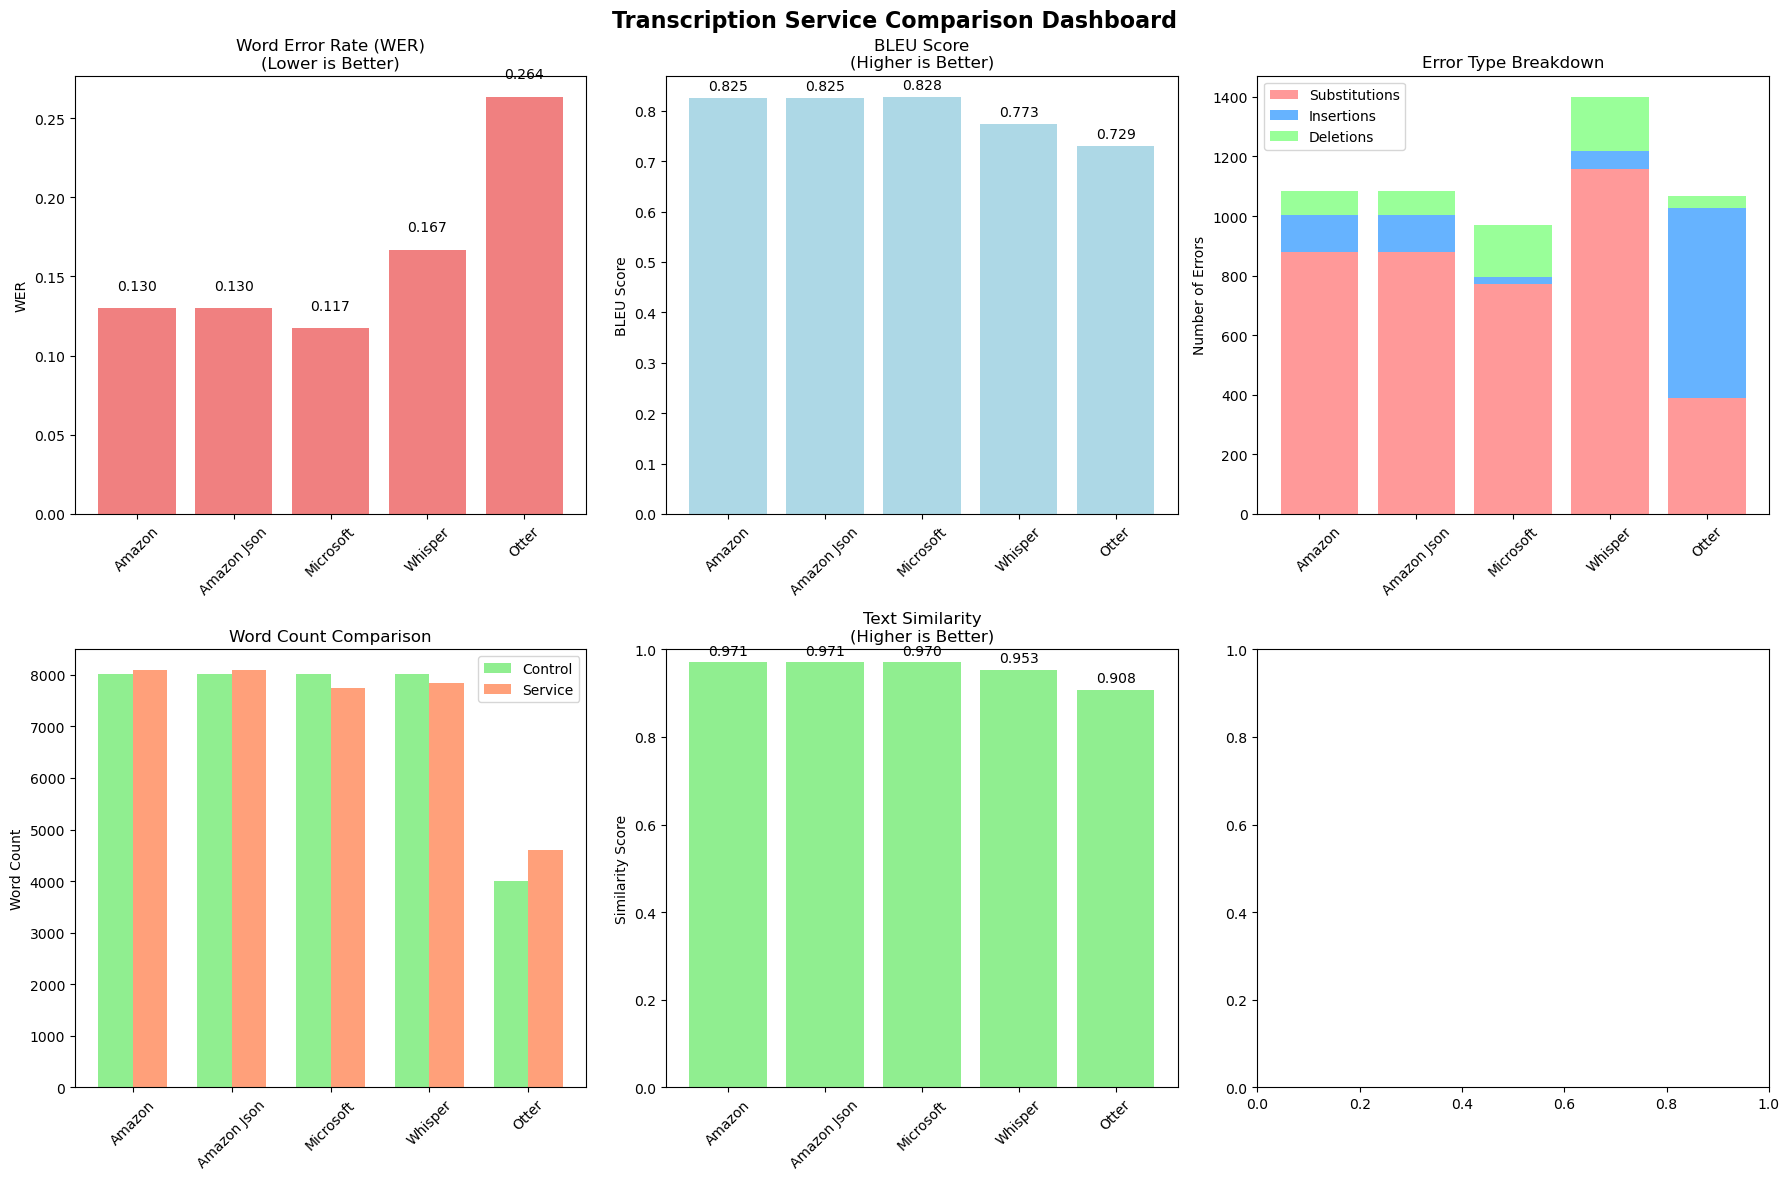

In [11]:
# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Transcription Service Comparison Dashboard", fontsize=16, fontweight="bold")

# Prepare data for plotting
services = list(results.keys())
service_labels = [s.replace("_", " ").title() for s in services]

# 1. WER Comparison
wers = [results[s]["overall"]["wer"] for s in services]
bars1 = axes[0,0].bar(service_labels, wers, color="lightcoral")
axes[0,0].set_title("Word Error Rate (WER)\n(Lower is Better)")
axes[0,0].set_ylabel("WER")
axes[0,0].tick_params(axis="x", rotation=45)
# Add value labels on bars
for bar, wer in zip(bars1, wers):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f"{wer:.3f}", ha="center", va="bottom")

# 2. BLEU Score Comparison
bleus = [results[s]["overall"]["bleu"] for s in services]
bars2 = axes[0,1].bar(service_labels, bleus, color="lightblue")
axes[0,1].set_title("BLEU Score\n(Higher is Better)")
axes[0,1].set_ylabel("BLEU Score")
axes[0,1].tick_params(axis="x", rotation=45)
for bar, bleu in zip(bars2, bleus):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f"{bleu:.3f}", ha="center", va="bottom")

# 3. Error Type Breakdown
error_types = ["substitutions", "insertions", "deletions"]
error_data = np.array([[results[s]["overall"]["errors"][et] for et in error_types] for s in services])
bottom = np.zeros(len(services))
colors = ["#ff9999", "#66b3ff", "#99ff99"]

for i, error_type in enumerate(error_types):
    axes[0,2].bar(service_labels, error_data[:, i], bottom=bottom, 
                  label=error_type.title(), color=colors[i])
    bottom += error_data[:, i]

axes[0,2].set_title("Error Type Breakdown")
axes[0,2].set_ylabel("Number of Errors")
axes[0,2].legend()
axes[0,2].tick_params(axis="x", rotation=45)

# 4. Word Count Comparison
control_counts = [results[s]["overall"]["word_count_control"] for s in services]
service_counts = [results[s]["overall"]["word_count_service"] for s in services]

x = np.arange(len(services))
width = 0.35

axes[1,0].bar(x - width/2, control_counts, width, label="Control", color="lightgreen")
axes[1,0].bar(x + width/2, service_counts, width, label="Service", color="lightsalmon")
axes[1,0].set_title("Word Count Comparison")
axes[1,0].set_ylabel("Word Count")
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(service_labels, rotation=45)
axes[1,0].legend()

# 5. Similarity Scores
similarities = [results[s]["overall"]["similarity"] for s in services]
bars5 = axes[1,1].bar(service_labels, similarities, color="lightgreen")
axes[1,1].set_title("Text Similarity\n(Higher is Better)")
axes[1,1].set_ylabel("Similarity Score")
axes[1,1].tick_params(axis="x", rotation=45)
axes[1,1].set_ylim(0, 1)
for bar, sim in zip(bars5, similarities):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f"{sim:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

## 8. Summary and Recommendations {#summary}

In [13]:
# Create comprehensive summary report
def generate_service_ranking():
    """Generate overall service ranking based on multiple metrics."""
    service_scores = {}
    
    for service in services:
        overall = results[service]["overall"]
        
        # Composite score (weights can be adjusted based on priorities)
        score = (
            (1 - overall["wer"]) * 0.3 +      # WER (inverted, so lower is better)
            overall["bleu"] * 0.25 +          # BLEU score
            overall["similarity"] * 0.25 +    # Similarity
            0.2                                 # Placeholder for other factors
        )
        
        service_scores[service] = {
            "score": score,
            "wer": overall["wer"],
            "bleu": overall["bleu"],
            "similarity": overall["similarity"]
        }
    
    # Sort by score (descending)
    ranked_services = sorted(service_scores.items(), key=lambda x: x[1]["score"], reverse=True)
    
    return ranked_services

def create_recommendation_matrix():
    """Create use-case specific recommendations."""
    recommendations = {
        "Overall Best": "Based on combined metrics",
        "Best for Accuracy": "Lowest Word Error Rate",
        "Most Complete": "Highest word count vs control"
    }
    
    # Find best service for each category
    best_overall = min(services, key=lambda s: results[s]["overall"]["wer"])
    best_accuracy = min(services, key=lambda s: results[s]["overall"]["wer"])
    best_complete = max(services, key=lambda s: results[s]["overall"]["word_count_service"])
    
    category_winners = {
        "Overall Best": best_overall,
        "Best for Accuracy": best_accuracy,
        "Most Complete": best_complete
    }
    
    return category_winners

# Generate ranking and recommendations
ranked_services = generate_service_ranking()
category_winners = create_recommendation_matrix()

print("="*80)
print("FINAL TRANSCRIPTION SERVICE COMPARISON REPORT")
print("="*80)

print(f"\nOVERALL RANKING (by composite score):")
print("-" * 50)
for i, (service, metrics) in enumerate(ranked_services, 1):
    service_name = service.replace("_", " ").title()
    print(f"{i}. {service_name:15} | Score: {metrics['score']:.3f} | WER: {metrics['wer']:.3f} | BLEU: {metrics['bleu']:.3f}")

print(f"\nCATEGORY WINNERS:")
print("-" * 50)
for category, winner in category_winners.items():
    winner_name = winner.replace("_", " ").title()
    print(f"{category:20}: {winner_name}")

print("\n" + "="*80)

FINAL TRANSCRIPTION SERVICE COMPARISON REPORT

OVERALL RANKING (by composite score):
--------------------------------------------------
1. Microsoft       | Score: 0.914 | WER: 0.117 | BLEU: 0.828
2. Amazon          | Score: 0.910 | WER: 0.130 | BLEU: 0.825
3. Amazon Json     | Score: 0.910 | WER: 0.130 | BLEU: 0.825
4. Whisper         | Score: 0.882 | WER: 0.167 | BLEU: 0.773
5. Otter           | Score: 0.830 | WER: 0.264 | BLEU: 0.729

CATEGORY WINNERS:
--------------------------------------------------
Overall Best        : Microsoft
Best for Accuracy   : Microsoft
Most Complete       : Amazon

